# global-umap-figure
7.25.24

In [1]:
import pandas as pd
import numpy as np 
import torch
from tqdm import tqdm
import os
import sys
import umap
from sklearn.decomposition import PCA
import sklearn.cluster as cluster

import matplotlib.pyplot as plt
import seaborn as sns

# plotting templates
sns.set(context="talk", style="ticks") 
pal = sns.color_palette("tab10")

/net/noble/vol2/home/lincolnh/miniconda3/envs/deep-impute/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


#### Configs

In [33]:
CORUM_df_path="/net/noble/vol2/home/lincolnh/data/humanComplexes.txt"

# The Lupine ensemble imputed matrix
lupine_recon_path="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2024-02-20_dream_compare/ensemble-normalized/results/lupine-ensemble-recon.csv"

# The unimputed joint quants matrix
joint_fname="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2024-02-20_dream_compare/ensemble-normalized/data/lupine-train-pandas.csv"

# The Ensemble (GENCODEv44) fasta
ensembl_path="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2023-11-13_UMich_dataset/fastas/"
ensembl_df="gencode.v44.pc_translations.fa"

# The HGNC database file
hgnc_database_path="/net/noble/vol2/home/lincolnh/data/quant-data/HGNC_database.txt"

# The handbuilt metadata file
meta_path="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2024-05-10_metadata_mapping/meta-dict.csv"

cohorts=["BRCA", "CCRCC", "COAD", "GBM", "HGSC", 
         "HNSCC", "LSCC", "LUAD", "PDAC", "UCEC"]

# For the unimputed joint quants matrix
min_pres=18

# For the decoy protein search
rng = np.random.default_rng(seed=18)
# alpha = 0.01

# For plotting
cust_palette = ["#ff7f0e", "#1f77b4"]

# UMAP configs
#   A lower value of `k_neighbors` will prioritize local structure, a 
#   higher value will prioritize global structure
k_neighbors=32
min_dist=0.9
rand_state=42

#### Functions

In [34]:
def run_umap(mat):
    """
    Runs the UMAP with scikit learn's UMAP function. Default is
    to reduce to two UMAP components. The rest of the UMAP 
    params are globally declared. 
    
    Parameters
    ----------
    mat : np.array, 
        The matrix to run UMAP on. Note that this will be 
        transposed. 
    
    Returns
    ----------
    df : pandas.DataFrame,
        A dataframe containing the UMAP dimensions as separate
        columns.
    """
    # Init the UMAP object
    reducer = umap.UMAP(
                n_neighbors=k_neighbors,
                n_components=2,
                min_dist=min_dist,
                random_state=rand_state,
                low_memory=True,
    )
    # Get the UMAP projections. Note that we're TRANSPOSING the input
    #    matrix here.
    dims = reducer.fit_transform(mat.T)

    # Save results to a dataframe
    df = pd.DataFrame(dims, columns=["UMAP1", "UMAP2"])
    return df

def splitter(x):
    """Splits the input, returns left of the comma."""
    return x.split(",")[0]

def get_tmt_batch_dict(tmt_meta):
    """
    Create a dictionary mapping the sample IDs to the TMT batch 
    labels. For a single metadata input file. Why do there seem to
    be duplicated sample IDs? 
    
    Parameters
    ----------
    tmt_meta : `pandas.DataFrame`
        The reagent label to biospecimine metadata file, for a 
        single PDC ID. 
    
    Returns
    ----------
    samples_dict : dictionary, 
        A dictionary mapping the sample IDs in the current cohort
        to their respective TMT batch label 
    """
    tmt_meta.index = tmt_meta["Run Metadata ID"]
    tmt_meta = tmt_meta.drop(columns=["Run Metadata ID"])

    samples_dict = {}

    for i in range(0, tmt_meta.shape[0]):
        for j in range(0, tmt_meta.shape[1]):
            curr = tmt_meta.iloc[i,j]
            samples_dict[curr] = tmt_meta.index[i]
            
    return samples_dict

def random_draw_impute(vec):
    """
    Imputes for a single *column* at a time using the Gaussian
    random draw procedure. This closely resembles the Perseus
    procedure described here: 
    https://cox-labs.github.io/coxdocs/replacemissingfromgaussian.html
    This is the newer (more accurate) version of this function. 
    
    Parameters
    ----------
    vec : np.array, 
        A 1D vector, that is, column from the matrix
        to be imputed. 

    Returns
    ----------
    vec_recon : np.array, 
        The imputed vector
    """
    width_param=0.3
    downshift_param=1.8
    
    # Get the means and std
    v_mean = np.nanmean(vec)
    v_std = np.nanstd(vec)
    
    # Get the locations of the MVs
    nans = np.isnan(vec)
    vec_recon = vec.copy()
    
    # How many total MVs? 
    n_mv = np.count_nonzero(nans)
    
    center = v_mean - (v_std * downshift_param)

    # Replace missing values with random draws
    vec_recon[nans] = rng.normal(
                        loc=center,
                        scale=v_std*width_param,
                        size=n_mv
    )
    # Make sure we don't have any negative values
    vec_recon = np.abs(vec_recon)
    
    return vec_recon

def min_impute(mat):
    """
    Take the minimum value of each column, replace missing values with
    this, return the reconstructed matrix.
    
    Parameters
    ----------
    mat : np.ndarray, 
        The matrix to impute
    
    Returns
    -----------
    cm_imputed : np.ndarray, 
        The column min imputed matrix.  
    """
    cm_imputed = mat.copy()

    # Get the column mins
    col_mins = np.nanmin(cm_imputed, axis=0)

    # Get the indices that contain NaNs
    nan_idxs = np.where(np.isnan(cm_imputed))

    # Replace the NaNs with their corresponding col mins
    for x, y in zip(nan_idxs[0], nan_idxs[1]):
        col_min = col_mins[y]
        cm_imputed[x,y] = col_min

    return cm_imputed

#### Read in the metadata, then do some operations

In [35]:
meta = pd.read_csv(meta_path)

#### Standardize the metadata `sample_type` labels

In [36]:
for i in range(0, meta.shape[0]):
    curr = meta.iloc[i]
    if curr["sample_type"] == "Primary Tumor":
        meta.loc[i, "sample_type"] = "Tumor"
    elif curr["sample_type"] == "Solid Tissue Normal":
        meta.loc[i, "sample_type"] = "Non-tumor"
    elif curr["sample_type"] == "Normal":
        meta.loc[i, "sample_type"] = "Non-tumor"
    elif curr["sample_type"] == "Not Reported":
        meta.loc[i, "sample_type"] = np.nan
    elif curr["sample_type"] == "Unknown":
        meta.loc[i, "sample_type"] = np.nan
    elif curr["sample_type"] == "C":
        meta.loc[i, "sample_type"] = np.nan

#### Generate a TMT sample ID to batch dictionary 

In [37]:
tmt_mapping_meta_path="/net/noble/vol2/home/lincolnh/data/quant-data/TMT-batch-to-sample/"
ftail = "_reagent_label_to_biospecimine_mapping.tsv"
cohorts_w_meta = ["PDC000110", "PDC000117", "PDC000118", 
                  "PDC000119", "PDC000120", "PDC000121", 
                  "PDC000127", "PDC000128", "PDC000149", 
                  "PDC000153", "PDC000176", "PDC000180", 
                  "PDC000198", "PDC000199", "PDC000204", 
                  "PDC000205", "PDC000221", "PDC000222", 
                  "PDC000224", "PDC000232", "PDC000237", 
                  "PDC000239", "PDC000245", "PDC000250", 
                  "PDC000251", "PDC000270", "PDC000325"]

tmt_batch_dict = {}
for cohort in cohorts_w_meta: 
    tmt_meta = pd.read_csv(tmt_mapping_meta_path + cohort + ftail, sep="\t")
    tmt_meta = tmt_meta.drop(columns=["Number of Fractions"])
    tmt_meta = tmt_meta.applymap(splitter)
    
    curr_dict = get_tmt_batch_dict(tmt_meta)
    
    tmt_batch_dict.update(curr_dict)

/tmp/2556770.1.noble-login.q/ipykernel_969924/1117261479.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tmt_meta = tmt_meta.applymap(splitter)
/tmp/2556770.1.noble-login.q/ipykernel_969924/1117261479.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tmt_meta = tmt_meta.applymap(splitter)
/tmp/2556770.1.noble-login.q/ipykernel_969924/1117261479.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tmt_meta = tmt_meta.applymap(splitter)
/tmp/2556770.1.noble-login.q/ipykernel_969924/1117261479.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tmt_meta = tmt_meta.applymap(splitter)
/tmp/2556770.1.noble-login.q/ipykernel_969924/1117261479.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tmt_meta = tmt_meta.applymap(splitter)
/tmp/2556770.1.noble-login.q/ipykernel_969924/1117261479.py:17: F

#### Read in the imputed and unimputed joint quants

In [38]:
lupine_recon = pd.read_csv(lupine_recon_path, index_col=0)
joint_unimputed = pd.read_csv(joint_fname, index_col=0)

lupine_recon.columns = joint_unimputed.columns
lupine_recon.index = joint_unimputed.index

#### Remove extraneous rows and columns from the unimputed matrix

In [39]:
# Remove some of these extraneous runs
keywords = ["RefInt", "QC", "pool", "Tumor", "Pooled", 
            "Pool", "Reference", "NCI", "NX", "Ref"]
to_drop = []

for sample_id in list(joint_unimputed.columns):
    exclude=False
    for kw in keywords:
        if kw in sample_id:
            exclude=True
            break
    to_drop.append(exclude)

keep_cols = np.array(joint_unimputed.columns)[~np.array(to_drop)]
unimputed = joint_unimputed[keep_cols]

unimputed = np.array(unimputed)

# Remove proteins with too many missing values
num_present = np.sum(~np.isnan(unimputed), axis=1)
discard = num_present < min_pres
unimputed = np.delete(unimputed, discard, axis=0)
keep_prots = np.array(joint_unimputed.index)[~discard]

unimputed = pd.DataFrame(unimputed, index=keep_prots, columns=keep_cols)

#### Repeat for the Lupine imputed quants matrix

In [40]:
lupine_recon = lupine_recon[keep_cols].loc[keep_prots]

print(unimputed.shape)
print(lupine_recon.shape)

(17219, 1755)
(17219, 1755)


#### Remove proteins with >50% missingness at the cohort level 

In [41]:
# pres_frac_thresh=0.5

# num_present = np.sum(~np.isnan(unimputed), axis=1)
# pres_fracs = num_present / unimputed.shape[1]

# unimputed = unimputed[pres_fracs >= pres_frac_thresh]
# lupine_recon = lupine_recon[pres_fracs >= pres_frac_thresh]
# print(unimputed.shape)
# print(lupine_recon.shape)

# keep_prots_cohort = list(unimputed.index)

#### Impute with Gaussian random sample

In [42]:
grs_imputed = np.apply_along_axis(random_draw_impute, 0, np.array(unimputed))
#grs_imputed = min_impute(np.array(unimputed))
grs_imputed = pd.DataFrame(grs_imputed, index=unimputed.index, 
                                  columns=unimputed.columns)

#### Get the global UMAP coordinates
For both imputation methods. 

In [43]:
umapper_lupine = run_umap(lupine_recon)
umapper_grs = run_umap(grs_imputed)

/net/noble/vol2/home/lincolnh/miniconda3/envs/deep-impute/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/net/noble/vol2/home/lincolnh/miniconda3/envs/deep-impute/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/net/noble/vol2/home/lincolnh/miniconda3/envs/deep-impute/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/net/noble/vol2/home/lincolnh/miniconda3/envs/deep-impute/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWar

#### Construct a dataframe to hold UMAP coords along with associated metadata

In [44]:
cols = ["aliquot_ID", "sample_ID", "sample_type", "primary_site", "disease_type", "cohort", 
        "UMAP1_Lupine", "UMAP2_Lupine", "UMAP1_GRS", "UMAP2_GRS", ]
umapper_joint = pd.DataFrame(columns=cols)

umapper_joint["UMAP1_Lupine"] = umapper_lupine["UMAP1"]
umapper_joint["UMAP2_Lupine"] = umapper_lupine["UMAP2"]

umapper_joint["UMAP1_GRS"] = umapper_grs["UMAP1"]
umapper_joint["UMAP2_GRS"] = umapper_grs["UMAP2"]

#### Map on the sample IDs, sample types and cohorts

In [45]:
umapper_joint["aliquot_ID"] = lupine_recon.columns
sample_ids = []
sample_types = []
cohorts = []

for idx in range(0, umapper_joint.shape[0]):
    a_id = umapper_joint.iloc[idx]["aliquot_ID"]
    meta_row = meta[meta["aliquot_ID"] == a_id]
    s_id = meta_row["sample_ID"].item()
    s_type = meta_row["sample_type"].item()
    cohort = meta_row["cohort"].item()

    sample_ids.append(s_id)
    sample_types.append(s_type)
    cohorts.append(cohort)

umapper_joint["sample_ID"] = sample_ids
umapper_joint["sample_type"] = sample_types
umapper_joint["cohort"] = cohorts

#### Add the TMT batch IDs

In [46]:
umapper_joint["TMT_batch"] = None

for idx in range(0, umapper_joint.shape[0]):
    s_id = umapper_joint.iloc[idx]["sample_ID"]
    if s_id in tmt_batch_dict:
        tmt_batch = tmt_batch_dict[s_id]
        umapper_joint.loc[idx, "TMT_batch"] = tmt_batch

#### Get the 2x2 batch effects plot for a single cohort
This will have two columns: Lupine colored by sample type, GRS colored by sample type and
GRS colored by TMT batch. 

/tmp/2556770.1.noble-login.q/ipykernel_969924/1125627812.py:29: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg1.legendHandles:
/tmp/2556770.1.noble-login.q/ipykernel_969924/1125627812.py:58: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg2.legendHandles:


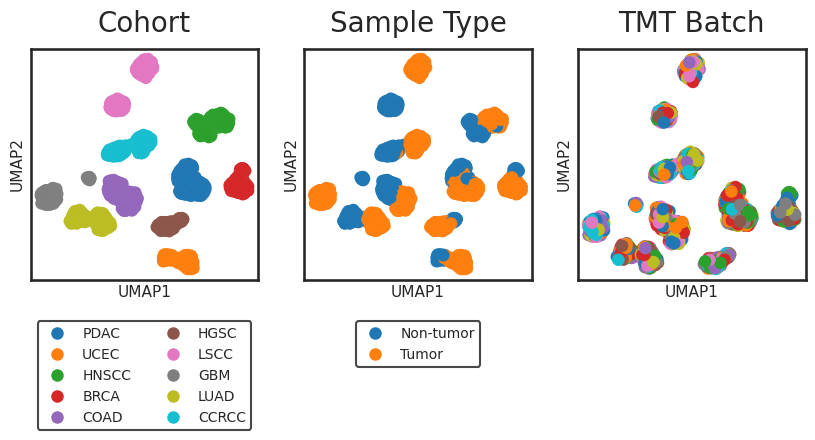

In [54]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,3))

# LUPINE - COLOR BY SAMPLE TYPE
sns.scatterplot(
    data=umapper_joint,
    x="UMAP1_Lupine",
    y="UMAP2_Lupine",
    alpha=1.0,
    hue="cohort",
    palette="tab10",
    linewidth=0.01,
    ax=ax1
)
ax1.set_title("Cohort", pad=12, size=20)
ax1.set_xlabel("UMAP1", labelpad=4, size=11)
ax1.set_ylabel("UMAP2", labelpad=4, size=11)

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
#ax1.get_legend().remove()

leg1 = ax1.legend(
            loc="upper center", 
            bbox_to_anchor=(0.5, -0.15), 
            fancybox=True,
            edgecolor="k", 
            prop={"size":10}, ncol=2,
)
for lh in leg1.legendHandles: 
    lh.set_alpha(1)

# LUPINE - COLOR BY TMT BATCH 
sns.scatterplot(
    data=umapper_joint,
    x="UMAP1_Lupine",
    y="UMAP2_Lupine",
    alpha=1.0,
    hue="sample_type",
    palette="tab10",
    linewidth=0.01,
    ax=ax2,
)
ax2.set_title("Sample Type", pad=12, size=20)
ax2.set_xlabel("UMAP1", labelpad=4, size=11)
ax2.set_ylabel("UMAP2", labelpad=4, size=11)

ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax2.get_legend().remove()

leg2 = ax2.legend(
            loc="upper center", 
            bbox_to_anchor=(0.5, -0.15), 
            fancybox=True,
            edgecolor="k", 
            prop={"size":10},
)
for lh in leg2.legendHandles: 
    lh.set_alpha(1)

# NAIVE - COLOR BY SAMPLE TYPE
sns.scatterplot(
    data=umapper_joint,
    x="UMAP1_Lupine",
    y="UMAP2_Lupine",
    alpha=1.0,
    hue="TMT_batch",
    palette="tab10",
    linewidth=0.01,
    ax=ax3,
)
ax3.set_title("TMT Batch", pad=12, size=20)
ax3.set_xlabel("UMAP1", labelpad=4, size=11)
ax3.set_ylabel("UMAP2", labelpad=4, size=11)

ax3.get_xaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])
ax3.get_legend().remove()

plt.show()
#plt.savefig("../figures/global-umaps.png", bbox_inches="tight", dpi=250)
#plt.savefig("../figures/global-umaps-v1.pdf", bbox_inches="tight")